In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
#sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(10,6)})

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    plot_roc_curve,
    precision_score,
    balanced_accuracy_score,
    recall_score,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    plot_precision_recall_curve,
    average_precision_score,
    auc)


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (RepeatedStratifiedKFold, StratifiedKFold)

In [2]:
## Confusion Matrix
def conf_matrix(y_test, y_pred):
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_norm = cf_matrix.astype("float") / cf_matrix.sum(axis=1)[:, np.newaxis] # normalize it

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = ['({0:.2%})'.format(value) for value in cf_norm.flatten()]
    group_counts = ['Count = {0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, group_counts)]
    labels = np.asarray(labels).reshape(2,2)


    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues') #cmap='binary' #cmap='Blues'

    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label")

    plt.show(block=False)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
path = r"C:\Users\yudhi\OneDrive\Desktop\School\Courses\Data_Mining\Data"
os.chdir(path)

In [5]:
#read data in chunks of 1 million rows at a time
df = pd.read_csv('output1.csv', dtype='object')

df.head(3)

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Necrophilia,AteBody,...,Dismembered,TakenHome,VicSex,Race of Victim,Primary Victim Age_Adults,Primary Victim Age_Various,Primary Victim Age_Rare,Sex,Race,Age Group
0,0,0,0,1,0,0,1,0,0,0,...,0,0,2,2,1,0,0,0,1.0,2.0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,3,1,0,0,0,2.0,2.0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,1,7,1,0,0,0,1.0,2.0


In [6]:
df.dtypes

Sexual Assault                object
Torture                       object
Sought victim to kill         object
Overkill                      object
Quick                         object
Blindfold                     object
Bound                         object
Mutilate                      object
Necrophilia                   object
AteBody                       object
DrankBlood                    object
Posed                         object
Body Totem                    object
BodyLeft                      object
LeftHidden                    object
LeftBuried                    object
Moved                         object
MovedHide                     object
MovedBuried                   object
Placed in body of water       object
Body Burned                   object
Dismembered                   object
TakenHome                     object
VicSex                        object
Race of Victim                object
Primary Victim Age_Adults     object
Primary Victim Age_Various    object
P

In [7]:
df.describe()

,Sexual Assault,Torture,Sought victim to kill,Overkill,Quick,Blindfold,Bound,Mutilate,Necrophilia,AteBody,...,Dismembered,TakenHome,VicSex,Race of Victim,Primary Victim Age_Adults,Primary Victim Age_Various,Primary Victim Age_Rare,Sex,Race,Age Group
count,2875,2875,2875,2875,2875,2875,2875,2875,2875,2875,...,2875,2875,2875,2875,2875,2875,2875,2875,2875,2875
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,3,7,2,2,2,2,4,4
top,0,0,1,0,0,0,0,0,0,0,...,0,0,3,1,1,0,0,0,0.0,1.0
freq,2025,2614,2372,2426,2370,2839,2411,2722,2813,2860,...,2756,2855,1217,1401,2290,2554,2706,2706,1359,1435


In [8]:
df.isnull().sum()

Sexual Assault                0
Torture                       0
Sought victim to kill         0
Overkill                      0
Quick                         0
Blindfold                     0
Bound                         0
Mutilate                      0
Necrophilia                   0
AteBody                       0
DrankBlood                    0
Posed                         0
Body Totem                    0
BodyLeft                      0
LeftHidden                    0
LeftBuried                    0
Moved                         0
MovedHide                     0
MovedBuried                   0
Placed in body of water       0
Body Burned                   0
Dismembered                   0
TakenHome                     0
VicSex                        0
Race of Victim                0
Primary Victim Age_Adults     0
Primary Victim Age_Various    0
Primary Victim Age_Rare       0
Sex                           0
Race                          0
Age Group                     0
dtype: i

In [9]:
# separate into training and testing set
X = df.drop(labels=['Sex', 'Race', 'Age Group'], axis=1)
y = df[['Sex', 'Race', 'Age Group']]
X_train,X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify = y,
                                                    random_state=0)

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RandomUnderSampler

In [11]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_test.Sex)
type_of_target(y_test.Race)

'multiclass'

In [12]:
y_test.Sex.value_counts()

0    811
1     52
Name: Sex, dtype: int64

## Gender

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
def binary_classifier(model, X_train, X_test, y_train, y_test):
    # Logistic Regression

    over = SMOTE(sampling_strategy=0.1, k_neighbors=7)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)

    # Leave P Out Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    # estimate generalization error
    clf =  cross_validate(
        model,
        X_train, 
        y_train,
        scoring='accuracy',
        return_train_score=True,
        cv=skf, # k-fold
    )

    print('Cross-validation accuracy in 5-fold = ', clf['train_score'])

    scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    print('Mean ROC AUC cross-validation: %.3f' % np.mean(scores))

    # Train the model on training data
    pipeline.fit(X_train, y_train);
    # Use the forest's predict method on the test data
    y_pred = pipeline.predict(X_test)
    print('ROC-AUC test:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    print('Balanced accuracy: ', balanced_accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    conf_matrix(y_test, y_pred)

Cross-validation accuracy in 5-fold =  [0.94220012 0.94220012 0.94161491 0.94161491 0.94161491]
Mean ROC AUC cross-validation: 0.739
ROC-AUC test: 0.7722185336242056
Balanced accuracy:  0.6590154604951153
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       811
           1       0.27      0.38      0.32        52

    accuracy                           0.90       863
   macro avg       0.61      0.66      0.63       863
weighted avg       0.92      0.90      0.91       863



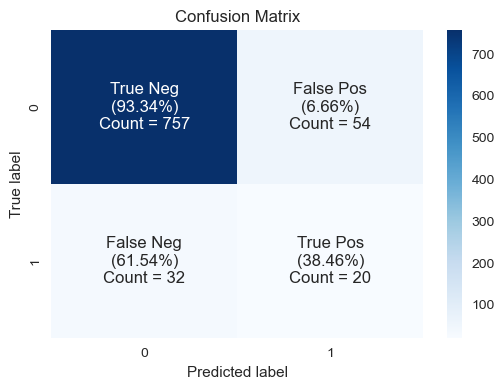

ValueError: The class provided by 'pos_label' is unknown. Got pos instead of one of {'0', '1'}

In [15]:
model = LogisticRegression(penalty ='l2', C=0.1, solver='liblinear', random_state=4, max_iter=1000)
binary_classifier(model, X_train, X_test, y_train.Sex, y_test.Sex)

logit_disp_roc = plot_roc_curve(model, X_test, y_test.Sex)
logit_disp_pr = plot_precision_recall_curve(model, X_test, y_test.Sex)

In [16]:
model = DecisionTreeClassifier(max_depth=4,min_samples_split=2)
binary_classifier(model, X_train, X_test, y_train.Sex, y_test.Sex)

dtc_disp_roc = plot_roc_curve(model, X_test, y_test.Sex)
dtc_disp_pr = plot_precision_recall_curve(model, X_test, y_test.Sex)

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

In [18]:
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
binary_classifier(model, X_train, X_test, y_train.Sex, y_test.Sex)

gbm_disp_roc = plot_roc_curve(model, X_test, y_test.Sex)
gbm_disp_pr = plot_precision_recall_curve(model, X_test, y_test.Sex)

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=2, n_jobs=4)
binary_classifier(model, X_train, X_test, y_train.Sex, y_test.Sex)

rf_disp_roc = plot_roc_curve(model, X_test, y_test.Sex)
rf_disp_pr = plot_precision_recall_curve(model, X_test, y_test.Sex)

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
model = KNeighborsClassifier(n_neighbors=100)
binary_classifier(model, X_train, X_test, y_train.Sex, y_test.Sex)

knn_disp_roc = plot_roc_curve(model, X_test, y_test.Sex)
knn_disp_pr = plot_precision_recall_curve(model, X_test, y_test.Sex)

In [22]:
from sklearn.ensemble import AdaBoostClassifier

In [23]:
model = AdaBoostClassifier(n_estimators = 100, learning_rate=1.0, random_state = 42)
binary_classifier(model, X_train, X_test, y_train.Sex, y_test.Sex)

ada_disp_roc = plot_roc_curve(model, X_test, y_test.Sex)
ada_disp_pr = plot_precision_recall_curve(model, X_test, y_test.Sex)

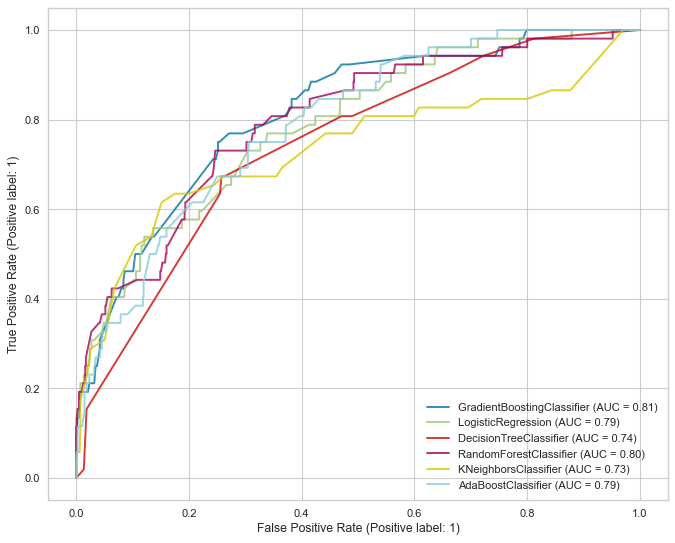

In [46]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
ax = plt.gca()
gbm_disp_roc.plot(ax=ax, alpha=0.8)
logit_disp_roc.plot(ax=ax, alpha=0.8)
dtc_disp_roc.plot(ax=ax, alpha=0.8)
rf_disp_roc.plot(ax=ax, alpha=0.8)
knn_disp_roc.plot(ax=ax, alpha=0.8)
ada_disp_roc.plot(ax=ax, alpha=0.8)

## Race

In [25]:
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTENC

In [26]:
def multiclass_classifier(model, X_train, X_test, y_train, y_test):
    # Logistic Regression
    over = SMOTE(sampling_strategy='not majority')
    under = RandomUnderSampler(sampling_strategy='auto')
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)

    # Leave P Out Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)

    # estimate generalization error
    clf =  cross_validate(
        pipeline,
        X_train, 
        y_train,
        scoring='accuracy',
        return_train_score=True,
        cv=skf, # k-fold
    )

    print('Cross-validation accuracy in 5-fold = ', clf['train_score'])

    # Train the model on training data
    pipeline.fit(X_train, y_train);
    # Use the forest's predict method on the test data
    y_pred = pipeline.predict(X_test)

    print(classification_report(y_test, y_pred))
    y_train_proba = pipeline.predict_proba(X_train)
    y_test_proba = pipeline.predict_proba(X_test)
    print('Balanced accuracy: ', balanced_accuracy_score(y_test, y_pred))
    
    # note that the predictions are an array of 4 columns

    # first column: the probability of an observation of being of class 0
    # second column: the probability of an observation of being of class 1
    # third column: the probability of an observation of being of class 2
    # third column: the probability of an observation of being of class 3

    macro_roc_auc_ovo = roc_auc_score(
        y_test, y_test_proba, multi_class="ovo", average="macro")

    weighted_roc_auc_ovo = roc_auc_score(
        y_test, y_test_proba, multi_class="ovo", average="weighted")

    macro_roc_auc_ovr = roc_auc_score(
        y_test, y_test_proba, multi_class="ovr", average="macro")

    weighted_roc_auc_ovr = roc_auc_score(
        y_test, y_test_proba, multi_class="ovr", average="weighted")

    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))

    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

Cross-validation accuracy in 5-fold =  [0.67930392 0.71286513 0.70124224 0.72236025 0.71925466]
              precision    recall  f1-score   support

         0.0       0.74      0.85      0.79       407
         1.0       0.83      0.58      0.68       372
         2.0       0.33      0.52      0.40        66
         3.0       0.05      0.11      0.07        18

    accuracy                           0.69       863
   macro avg       0.49      0.51      0.49       863
weighted avg       0.74      0.69      0.70       863

Balanced accuracy:  0.5116850721689431
One-vs-One ROC AUC scores:
0.744116 (macro),
0.772406 (weighted)
One-vs-Rest ROC AUC scores:
0.771952 (macro),
0.840517 (weighted)


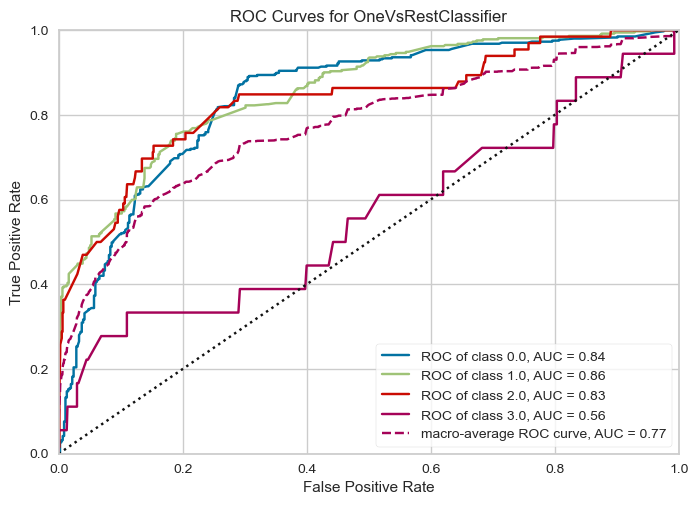

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [27]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4, n_jobs=4))
multiclass_classifier(model, X_train, X_test, y_train.Race, y_test.Race)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.Race)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.Race)        # Evaluate the model on the test data
visualizer.show()   

Cross-validation accuracy in 5-fold =  [0.4151647  0.51149782 0.45093168 0.47018634 0.43975155]
              precision    recall  f1-score   support

         0.0       0.83      0.44      0.58       407
         1.0       0.79      0.51      0.62       372
         2.0       0.26      0.64      0.37        66
         3.0       0.03      0.39      0.05        18

    accuracy                           0.49       863
   macro avg       0.48      0.49      0.41       863
weighted avg       0.75      0.49      0.57       863

Balanced accuracy:  0.4945664139212526
One-vs-One ROC AUC scores:
0.728956 (macro),
0.743755 (weighted)
One-vs-Rest ROC AUC scores:
0.738222 (macro),
0.783614 (weighted)


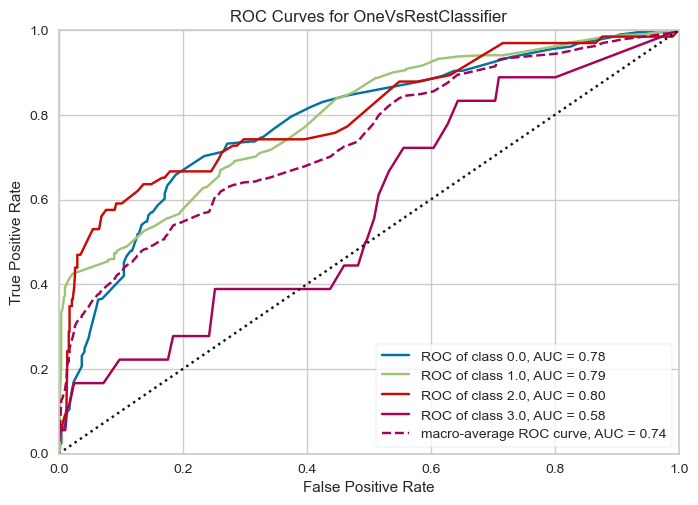

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [28]:
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=100))
multiclass_classifier(model, X_train, X_test, y_train.Race, y_test.Race)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.Race)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.Race)        # Evaluate the model on the test data
visualizer.show()    

Cross-validation accuracy in 5-fold =  [0.78682411 0.77750155 0.75590062 0.77888199 0.78136646]
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80       407
         1.0       0.80      0.70      0.75       372
         2.0       0.45      0.50      0.47        66
         3.0       0.22      0.11      0.15        18

    accuracy                           0.74       863
   macro avg       0.56      0.54      0.54       863
weighted avg       0.74      0.74      0.74       863

Balanced accuracy:  0.540769508511444
One-vs-One ROC AUC scores:
0.786269 (macro),
0.809238 (weighted)
One-vs-Rest ROC AUC scores:
0.809433 (macro),
0.865370 (weighted)


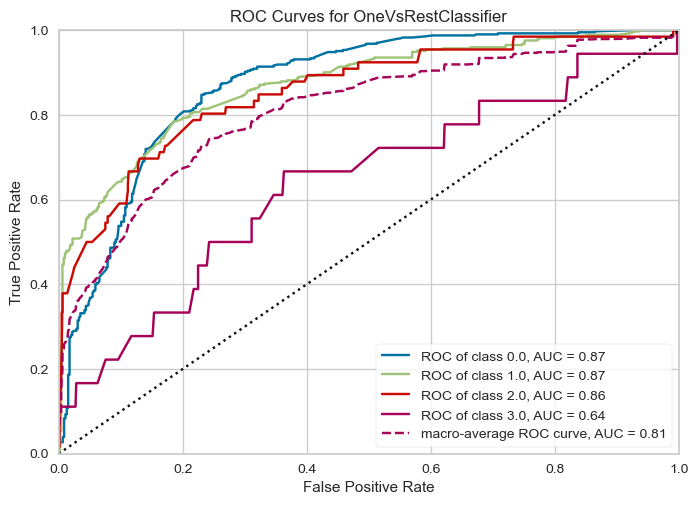

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [29]:
model = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0))
multiclass_classifier(model, X_train, X_test, y_train.Race, y_test.Race)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.Race)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.Race)        # Evaluate the model on the test data
visualizer.show()    

Cross-validation accuracy in 5-fold =  [0.66314481 0.65320075 0.67267081 0.7378882  0.64906832]
              precision    recall  f1-score   support

         0.0       0.75      0.86      0.80       407
         1.0       0.98      0.45      0.61       372
         2.0       0.24      0.73      0.36        66
         3.0       0.07      0.11      0.08        18

    accuracy                           0.65       863
   macro avg       0.51      0.53      0.46       863
weighted avg       0.79      0.65      0.67       863

Balanced accuracy:  0.5349143131401196
One-vs-One ROC AUC scores:
0.750030 (macro),
0.777306 (weighted)
One-vs-Rest ROC AUC scores:
0.773999 (macro),
0.848278 (weighted)


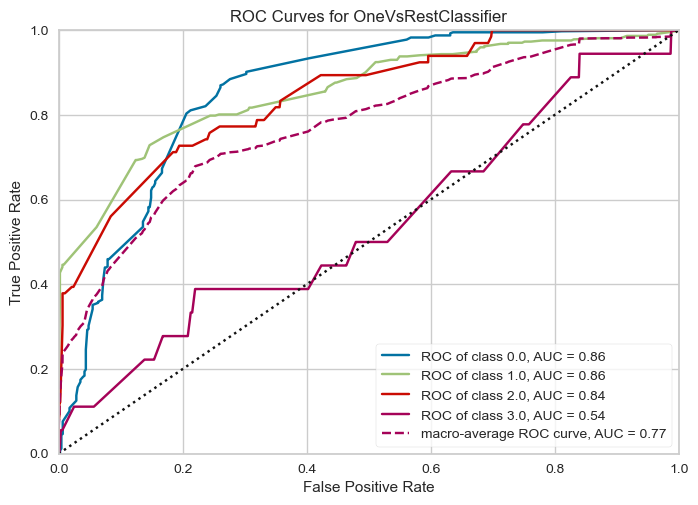

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [30]:
model = OneVsRestClassifier(DecisionTreeClassifier(max_depth=4,min_samples_split=2))
multiclass_classifier(model, X_train, X_test, y_train.Race, y_test.Race)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.Race)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.Race)        # Evaluate the model on the test data
visualizer.show()    

Cross-validation accuracy in 5-fold =  [0.4151647  0.43940336 0.4515528  0.47391304 0.45279503]
              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65       407
         1.0       0.65      0.25      0.36       372
         2.0       0.15      0.35      0.21        66
         3.0       0.02      0.22      0.04        18

    accuracy                           0.43       863
   macro avg       0.37      0.36      0.31       863
weighted avg       0.61      0.43      0.48       863

Balanced accuracy:  0.35991013007142036
One-vs-One ROC AUC scores:
0.612802 (macro),
0.638981 (weighted)
One-vs-Rest ROC AUC scores:
0.642656 (macro),
0.686675 (weighted)


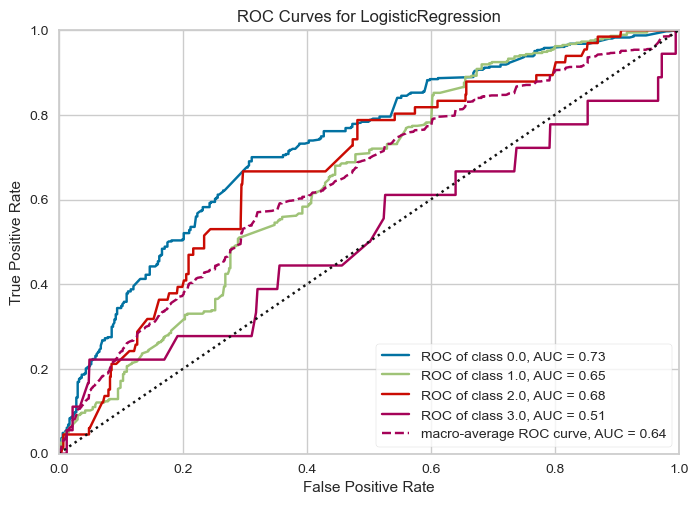

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [31]:
model = LogisticRegression(penalty ='l2', C=0.1, solver='newton-cg', random_state=4, max_iter=1000, multi_class='ovr')
multiclass_classifier(model, X_train, X_test, y_train.Race, y_test.Race)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.Race)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.Race)        # Evaluate the model on the test data
visualizer.show()    

In [ ]:
model = OneVsRestClassifier(AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=300,
    learning_rate=1.5,
    algorithm="SAMME"))
multiclass_classifier(model, X_train, X_test, y_train.Race, y_test.Race)

ada_disp_roc = plot_roc_curve(model, X_test, y_test.Race)
ada_disp_pr = plot_precision_recall_curve(model, X_test, y_test.Race)

## Age Group

In [32]:
y_train.rename(columns={'Age Group': 'AgeGroup'}, inplace=True)
y_test.rename(columns={'Age Group': 'AgeGroup'}, inplace=True)

In [33]:
y_train['AgeGroup'].value_counts()

1.0    1004
2.0     428
0.0     403
3.0     177
Name: AgeGroup, dtype: int64

Cross-validation accuracy in 5-fold =  [0.60720945 0.63331262 0.61801242 0.66086957 0.6173913 ]
              precision    recall  f1-score   support

         0.0       0.30      0.30      0.30       174
         1.0       0.52      0.54      0.53       431
         2.0       0.33      0.27      0.30       183
         3.0       0.19      0.23      0.20        75

    accuracy                           0.41       863
   macro avg       0.33      0.33      0.33       863
weighted avg       0.41      0.41      0.41       863

Balanced accuracy:  0.3334700131201753
One-vs-One ROC AUC scores:
0.604287 (macro),
0.595539 (weighted)
One-vs-Rest ROC AUC scores:
0.599364 (macro),
0.577928 (weighted)


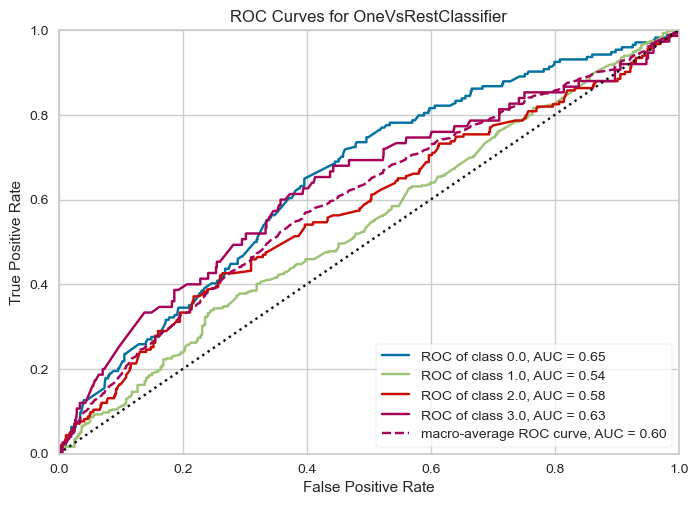

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [34]:
model = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0))
multiclass_classifier(model, X_train, X_test, y_train.AgeGroup, y_test.AgeGroup)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.AgeGroup)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.AgeGroup)        # Evaluate the model on the test data
visualizer.show()    

Cross-validation accuracy in 5-fold =  [0.30018645 0.30950901 0.31118012 0.31428571 0.31180124]
              precision    recall  f1-score   support

         0.0       0.28      0.48      0.35       174
         1.0       0.51      0.23      0.32       431
         2.0       0.24      0.17      0.20       183
         3.0       0.11      0.36      0.17        75

    accuracy                           0.28       863
   macro avg       0.29      0.31      0.26       863
weighted avg       0.37      0.28      0.29       863

Balanced accuracy:  0.3103933145252713
One-vs-One ROC AUC scores:
0.584169 (macro),
0.578688 (weighted)
One-vs-Rest ROC AUC scores:
0.580533 (macro),
0.567747 (weighted)


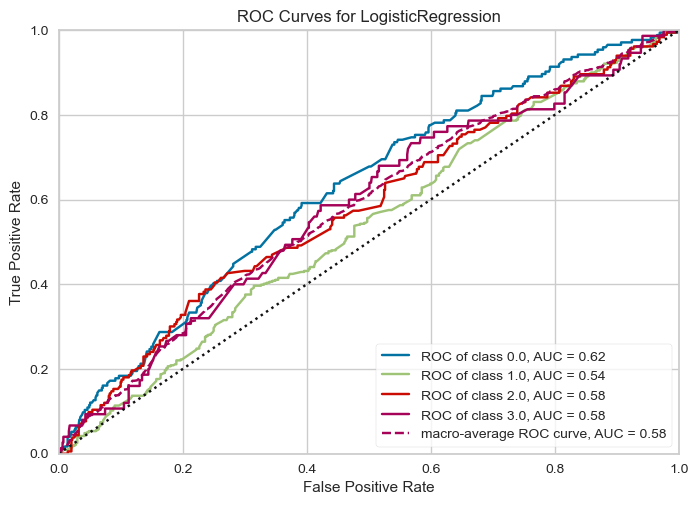

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [35]:
model = LogisticRegression(penalty ='l2', C=0.1, solver='newton-cg', random_state=4, max_iter=1000, multi_class='ovr')
multiclass_classifier(model, X_train, X_test, y_train.AgeGroup, y_test.AgeGroup)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.AgeGroup)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.AgeGroup)        # Evaluate the model on the test data
visualizer.show()    

Cross-validation accuracy in 5-fold =  [0.34244873 0.40522063 0.30807453 0.32173913 0.33664596]
              precision    recall  f1-score   support

         0.0       0.26      0.51      0.34       174
         1.0       0.55      0.15      0.23       431
         2.0       0.27      0.21      0.24       183
         3.0       0.12      0.40      0.18        75

    accuracy                           0.26       863
   macro avg       0.30      0.32      0.25       863
weighted avg       0.39      0.26      0.25       863

Balanced accuracy:  0.318275221580568
One-vs-One ROC AUC scores:
0.593405 (macro),
0.587885 (weighted)
One-vs-Rest ROC AUC scores:
0.586732 (macro),
0.577649 (weighted)


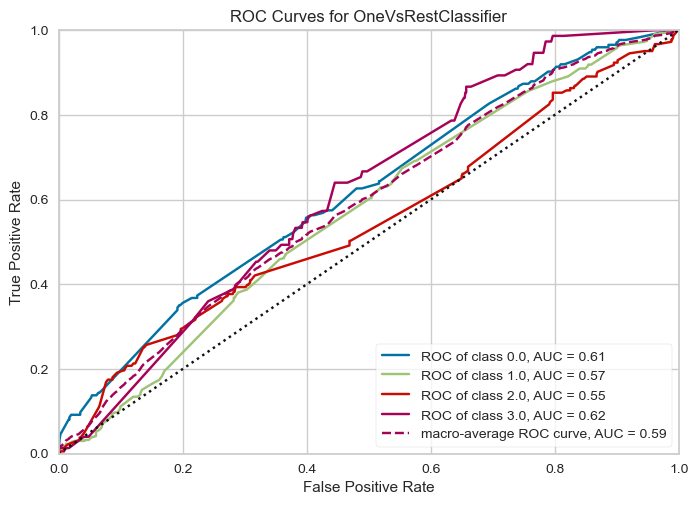

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [36]:
model = OneVsRestClassifier(DecisionTreeClassifier(max_depth=4,min_samples_split=5))
multiclass_classifier(model, X_train, X_test, y_train.AgeGroup, y_test.AgeGroup)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.AgeGroup)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.AgeGroup)        # Evaluate the model on the test data
visualizer.show()    

Cross-validation accuracy in 5-fold =  [0.38844002 0.39714108 0.39440994 0.39503106 0.3863354 ]
              precision    recall  f1-score   support

         0.0       0.29      0.43      0.34       174
         1.0       0.49      0.32      0.38       431
         2.0       0.28      0.19      0.22       183
         3.0       0.12      0.35      0.18        75

    accuracy                           0.31       863
   macro avg       0.30      0.32      0.28       863
weighted avg       0.37      0.31      0.32       863

Balanced accuracy:  0.3183229040836928
One-vs-One ROC AUC scores:
0.603417 (macro),
0.594394 (weighted)
One-vs-Rest ROC AUC scores:
0.600234 (macro),
0.576140 (weighted)


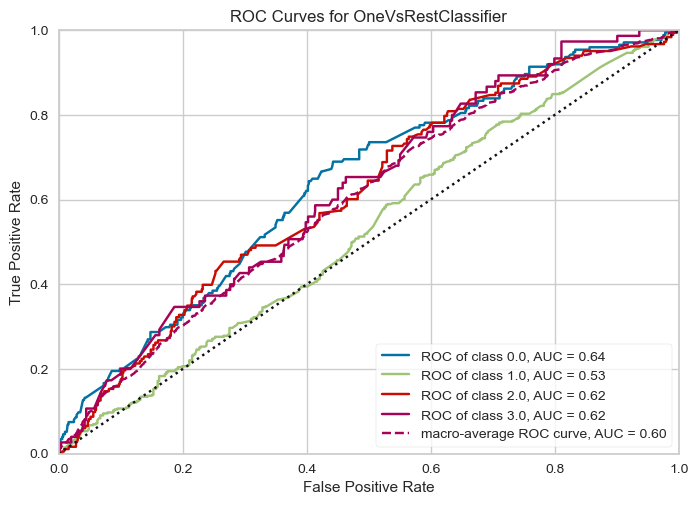

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [37]:
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4, n_jobs=4))
multiclass_classifier(model, X_train, X_test, y_train.AgeGroup, y_test.AgeGroup)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.AgeGroup)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.AgeGroup)        # Evaluate the model on the test data
visualizer.show()   

Cross-validation accuracy in 5-fold =  [0.2771908  0.26848975 0.28322981 0.28509317 0.28447205]
              precision    recall  f1-score   support

         0.0       0.27      0.35      0.30       174
         1.0       0.54      0.21      0.30       431
         2.0       0.23      0.25      0.24       183
         3.0       0.12      0.45      0.19        75

    accuracy                           0.27       863
   macro avg       0.29      0.31      0.26       863
weighted avg       0.38      0.27      0.28       863

Balanced accuracy:  0.3140765512607129
One-vs-One ROC AUC scores:
0.595068 (macro),
0.585620 (weighted)
One-vs-Rest ROC AUC scores:
0.587074 (macro),
0.570018 (weighted)


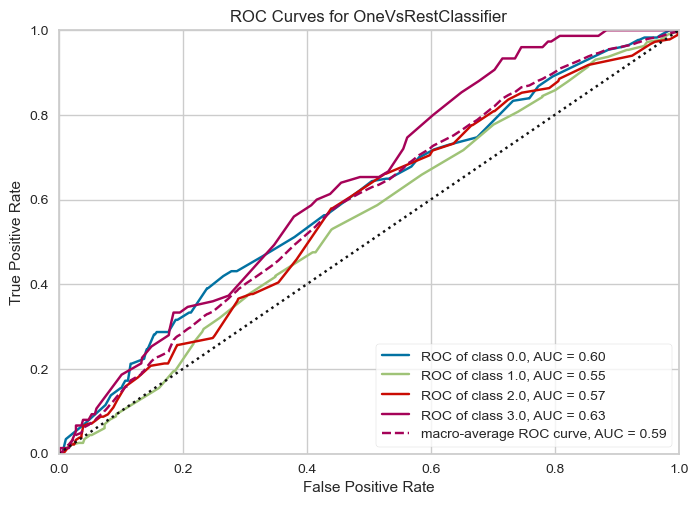

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [38]:
model = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=100))
multiclass_classifier(model, X_train, X_test, y_train.AgeGroup, y_test.AgeGroup)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.AgeGroup)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.AgeGroup)        # Evaluate the model on the test data
visualizer.show()    

Cross-validation accuracy in 5-fold =  [0.36171535 0.40087011 0.36708075 0.37639752 0.39006211]
              precision    recall  f1-score   support

         0.0       0.27      0.42      0.33       174
         1.0       0.50      0.37      0.42       431
         2.0       0.26      0.28      0.27       183
         3.0       0.14      0.13      0.14        75

    accuracy                           0.34       863
   macro avg       0.29      0.30      0.29       863
weighted avg       0.37      0.34      0.35       863

Balanced accuracy:  0.30206406676468545
One-vs-One ROC AUC scores:
0.586496 (macro),
0.576856 (weighted)
One-vs-Rest ROC AUC scores:
0.580329 (macro),
0.559145 (weighted)


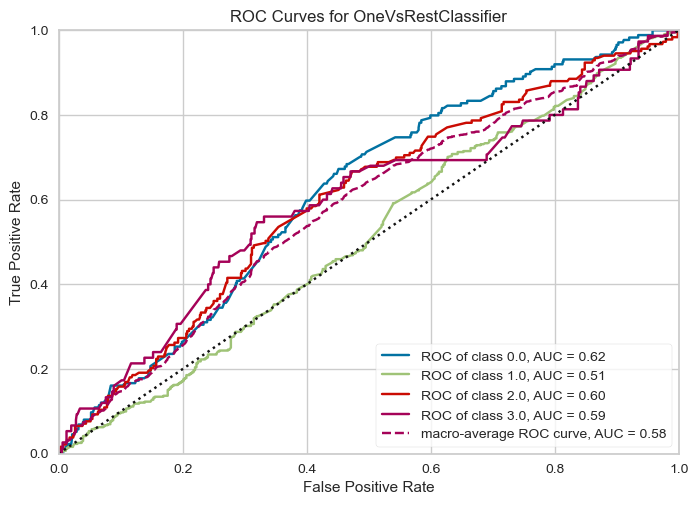

<AxesSubplot:title={'center':'ROC Curves for OneVsRestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [39]:
from sklearn.ensemble import AdaBoostClassifier
model = OneVsRestClassifier(AdaBoostClassifier())
multiclass_classifier(model, X_train, X_test, y_train.AgeGroup, y_test.AgeGroup)

visualizer = ROCAUC(
    model, per_class=True, cmap="cool", micro=False, cv=0.05,
)

visualizer.fit(X_train, y_train.AgeGroup)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test.AgeGroup)        # Evaluate the model on the test data
visualizer.show()    

In [40]:
y_train.AgeGroup = y_train.AgeGroup.astype(str).apply(lambda x: x.replace('.0',''))
y_test.AgeGroup = y_test.AgeGroup.astype(str).apply(lambda x: x.replace('.0',''))

In [41]:
y_train.dtypes

Sex         object
Race        object
AgeGroup    object
dtype: object

In [42]:
import tensorflow as tf
# sm = SMOTE(random_state = 2)
# X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train.AgeGroup.values.ravel())

# Set the random seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(5, activation="ReLU"),
  tf.keras.layers.Dense(2, activation="sigmoid")
])

# Compile the model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # ideal learning rate (same as default)
                 metrics=["accuracy"])

# Fit the model
history = model.fit(X_train, 
                    tf.one_hot(y_train, depth=4),
                       epochs=100,
                       validation_data=(X_test, tf.one_hot(y_test.AgeGroup, depth=4)))

InvalidArgumentError: Value for attr 'TI' of string is not in the list of allowed values: uint8, int32, int64
	; NodeDef: {{node OneHot}}; Op<name=OneHot; signature=indices:TI, depth:int32, on_value:T, off_value:T -> output:T; attr=axis:int,default=-1; attr=T:type; attr=TI:type,default=DT_INT64,allowed=[DT_UINT8, DT_INT32, DT_INT64]> [Op:OneHot]

In [ ]:
X_train.dtypes